### Import modules

In [1]:
import os
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

#map section
import imageio
import folium
import folium.plugins as plugins

import re
import string
from wordcloud import WordCloud, STOPWORDS
import nltk

os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")

from mpl_toolkits.basemap import Basemap

In [2]:
def getDataFrame(fileDir):
    data = []
    
    with open(fileDir, encoding="utf8") as data_file:
        for line in data_file:
            data.append(json.loads(line))
            
    return pd.DataFrame(data)

### Imported five dataframes below

In [3]:
business_df = getDataFrame("../archive/yelp_academic_dataset_business.json")
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Antiques, Fashion, Used, Vintage & Consignment...","{'Thursday': '11:0-18:0', 'Friday': '11:0-18:0..."
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Beauty & Spas, Hair Salons",None
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14,1,"{'GoodForKids': 'False', 'BusinessParking': '{...","Gyms, Active Life, Interval Training Gyms, Fit...","{'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0'..."


## Filter Rows

#### There are billions of lines of data in the dataframes imported above, let's just take a small fraction of the data
We are basing the data for areas around a city, for that let's see what city has the largest number of businesses

In [4]:
test_df = pd.DataFrame(columns=["city", "count"], data=[["Gotham",0]])
for state in business_df.city.unique():
    businessesInACity = business_df[business_df['city']==state]
    row={"city":state, "count":businessesInACity.shape[0]}
    test_df = test_df.append(row,ignore_index=True)

In [5]:
test_df = test_df.sort_values(by = 'count', ascending = False)
test_df.head()

,city,count
8,Austin,22416
2,Portland,18203
5,Vancouver,13330
4,Atlanta,12612
6,Orlando,10637


#### Now we are going to get businesses only within the top city: i.e. Austin

In [6]:
businessesInAustin = business_df[business_df['city']==test_df['city'].iloc[0]]
businessesInAustin.shape

(22416, 14)

there are 22416 businesses in Austin

In [7]:
businessesInAustin['state'].unique()

array(['TX', 'MN', 'CA', 'AL'], dtype=object)

OK, so there are Austin in these four states, let's change that!

In [8]:
businessesInAustin = businessesInAustin[businessesInAustin['state']=='TX']
businessesInAustin.shape

(22412, 14)

### now let's import reviews of only these businesses

In [9]:
#getting list of business IDs
listOfBusinessesID = businessesInAustin['business_id'].tolist()
listOfBusinessesID

['N3_Gs3DnX4k9SgpwJxdEfw',
 'tXvdYGvlEceDljN8gt2_3Q',
 'nTIhpR7MhsALPwg_Hh14EA',
 '8XyEpVdAO0o6iVkVxkWosQ',
 'NVfOn7TdnHbaGH97CVB_Qg',
 'Xw8tuI30T-xihpzwBV-zJg',
 's8eTWEtW5WcnL2kUxrOVmw',
 'NRPemqVb4qpWFF0Avq_6OQ',
 'XymxusqpIsZFmN_QNQW_fw',
 'Nhw7on5kevbomM-GzRXy_A',
 'bRsDZ44CD3uhGnRY3NeQhQ',
 'z-0oY7VxQMQw3JHvdPejrA',
 'MEC2RzMZwPxzz_9rr0Cpog',
 'gjMCRTs0IZbw9bZLG837Bg',
 'Z4UNrp2VpqiEuc39eDsjdg',
 'AzAT-AWII5PJVPIGB37tGQ',
 'qTdz29Nf3zoALiDDEKfWlw',
 'zcSOyUPQopa6f8MU_cdNGA',
 '0GMFteLQFzUogXFK9STGtA',
 'ipsTYb3c_OcuzmZZyhWh3w',
 'mHryNAZtrclEGwnBNfQWNQ',
 '0Q7svPlpg8YOy_mzsr6vww',
 'n4dg97jn6hYFLgFq_Mlkqw',
 'pewcbd-NCgj1LXJNifFA4g',
 '-0AVYSnp6IZtsm6QFeGIdw',
 'c7SpDCrvkoFWOsMQH1gmkQ',
 'Pk4ZwXwUU50BDn5gqw_rKg',
 'A40p61gnz_7orVAr9YYHPg',
 'p9_tl3SckaGUjToGCz2frA',
 '1-UieVZg_JBMq92xhF633A',
 '3DFvutUSvHebYJ0Lb1oW6g',
 'nyQlAZJwQX052OG5jes2CQ',
 'Ieelu69Y23nbjKG3OGfwnw',
 'IFB2K3BEZ2L_Mv5AbUD26Q',
 'fBvQQUk1-V9IUA8PbuYFWg',
 'k435gqoMV8HZTAqc1TaEpg',
 'LjQ_z_eYTvbPkdnxD_Ucrw',
 

In [10]:
#extracting reviews of businesses in Austin
'''
review_data=[]
with open("../archive/yelp_academic_dataset_review.json", encoding="utf8") as data_file:
        for line in data_file:
            sampleRow = json.loads(line)
            if(sampleRow['business_id'] in listOfBusinessesID):
                review_data.append(sampleRow)
review_df = pd.DataFrame(review_data)
review_df.head()
review_df.to_json('../archive/processed_reviews.json', orient='split')
'''

'\nreview_data=[]\nwith open("../archive/yelp_academic_dataset_review.json", encoding="utf8") as data_file:\n        for line in data_file:\n            sampleRow = json.loads(line)\n            if(sampleRow[\'business_id\'] in listOfBusinessesID):\n                review_data.append(sampleRow)\nreview_df = pd.DataFrame(review_data)\nreview_df.head()\nreview_df.to_json(\'../archive/processed_reviews.json\', orient=\'split\')\n'

In [11]:
review_df = pd.read_json('../archive/processed_reviews.json', orient='split') 
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Qv_lQb1Yu9DGsUO3r-enNw,Ngl83gs3n22SzLAsNw2znw,iZxfWlfNPXV_0S1xO8QNSQ,2,3,0,0,Disappointing. Bolt is a follow up of Fanny's ...,2013-01-02 18:12:15
1,m1GlqFGIN5eayrbb2IbRZg,B7YSV6r1ePAXc69FkDDuZw,wZgUAuDuEGPEzKK-PsngKQ,1,0,0,0,I wish I could give them zero stars. The call ...,2014-06-27 22:06:55
2,GDgXjXSZCA1iNQWD7OHXfg,1RCRKuHgP3FskGUVnmFdxg,mOnesB4IF9j6-ZmHoOHOig,4,0,0,0,I think their rice dishes are way better than ...,2017-05-26 03:05:46
3,OMGz2BaL3bzRvY2hEp1-wQ,d01SZKYmReEar7varZB0HQ,I2OblwJG8_XzFxxoHU0vVQ,4,5,1,1,I just had my lasik done last week and I am re...,2010-05-14 14:33:54
4,dprQ8G5J01mlV6Z5W19LtQ,ednTYrjsoD3HtpZ-Z29SAQ,AW_dMex_BXFzgBJFxAjDuQ,5,0,0,0,Erika was amazing! After months of trying to f...,2016-08-03 22:55:45


## Exploratory data Analysis on businesses in Austin, TX

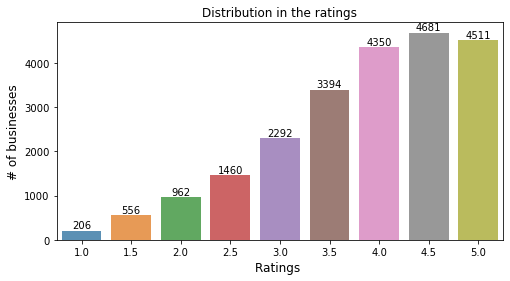

In [12]:
#Distributions on Ratings
x=businessesInAustin['stars'].value_counts()

x=x.sort_index()
plt.figure(figsize=(8,4))
ax= sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("Distribution in the ratings")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Ratings ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Most of the businesses in Austin have a high average Ratings

In [13]:
#Distribution on Business Categories
businessesInAustin["categories"].fillna('*', inplace = True)

businessCategories=''.join(businessesInAustin['categories'])
categoryFrame=pd.DataFrame([x.strip() for x in businessCategories.split(',')],columns=['category'])
x=categoryFrame.category.value_counts()
print("There are ",len(x)," different types/categories of Businesses in Austin!")


There are  15743  different types/categories of Businesses in Austin!


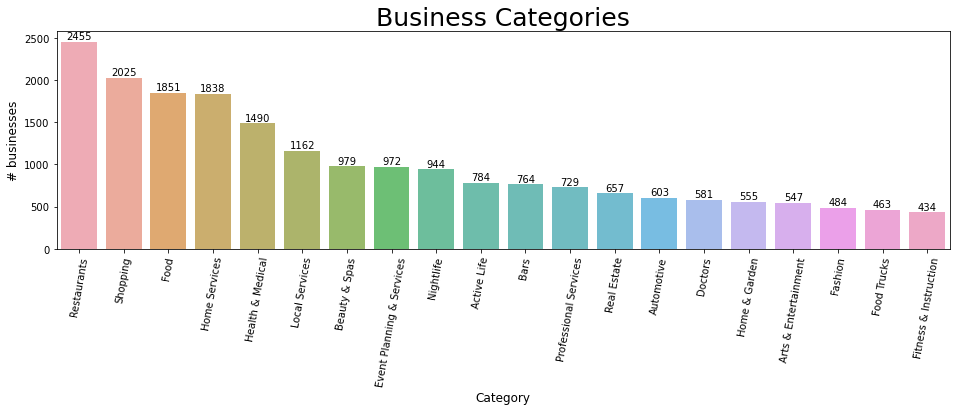

In [14]:
x=x.sort_values(ascending=False)
x=x.iloc[0:20]

#chart
plt.figure(figsize=(16,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("Business Categories",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [15]:
def createMaps(lon_min, lon_max, lat_min, lat_max, title):
    #create the selector
    idx_NA = (businessesInAustin["longitude"]>lon_min) &\
                (businessesInAustin["longitude"]<lon_max) &\
                (businessesInAustin["latitude"]>lat_min) &\
                (businessesInAustin["latitude"]<lat_max)
    #apply the selector to subset
    NA_business=businessesInAustin[idx_NA]

    #initiate the figure
    plt.figure(figsize=(12,6))
    m2 = Basemap(projection='merc',
                 llcrnrlat=lat_min,
                 urcrnrlat=lat_max,
                 llcrnrlon=lon_min,
                 urcrnrlon=lon_max,
                 lat_ts=35,
                 resolution='i')

    m2.fillcontinents(color='#bbdaa4',lake_color='#42c3eb') # dark grey land, black lakes
    m2.drawmapboundary(fill_color='#42c3eb')                # black background
    m2.drawcountries(linewidth=0.1, color="w")              # thin white line for country borders

    # Plot the data
    mxy = m2(NA_business["longitude"].tolist(), NA_business["latitude"].tolist())
    m2.scatter(mxy[0], mxy[1], s=5, c="#bd1e33", lw=0, alpha=0.05, zorder=5)
    plt.title(title)

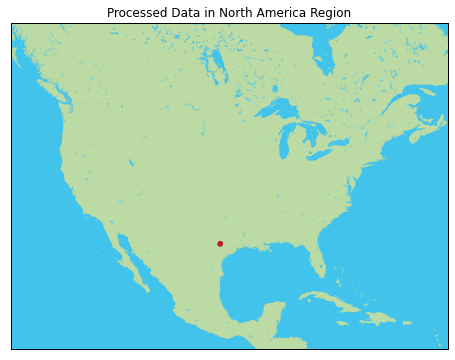

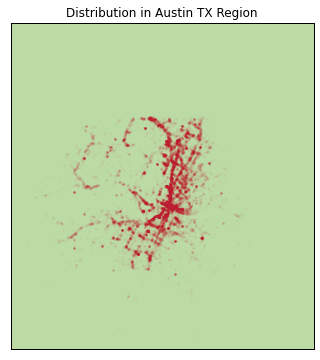

In [16]:
# North America
lon_min, lon_max = -132.714844, -59.589844
lat_min, lat_max = 13.976715,56.395664

createMaps(lon_min, lon_max, lat_min, lat_max, "Processed Data in North America Region")

#Area surrounding Austin TX
lon_min, lon_max = -98.121537, -97.400857
lat_min, lat_max = 29.972751,30.642378

createMaps(lon_min, lon_max, lat_min, lat_max, "Distribution in Austin TX Region")


### How businesses are getting reviewed over time?

#### Most reviewed businesses

Median review count 19.0


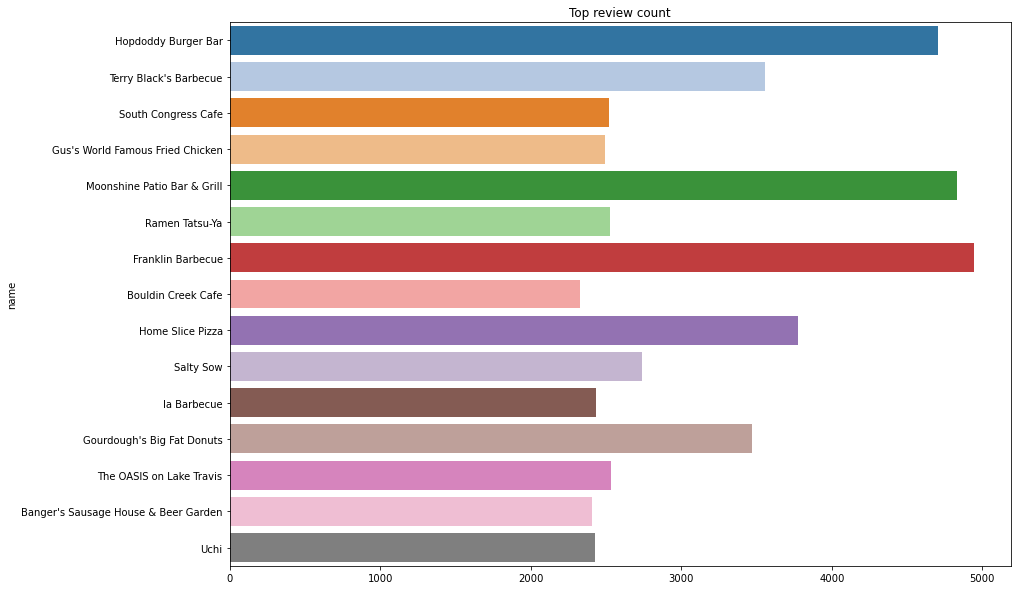

In [17]:
print('Median review count',businessesInAustin['review_count'].median())
plt.figure(figsize = (14,10))
sns.barplot(x= businessesInAustin[businessesInAustin['review_count'] >2000]['review_count'],y=businessesInAustin[businessesInAustin['review_count'] >2000]['name'],
           palette = 'tab20')
plt.xlabel('')
plt.title('Top review count');

#### What categories are the businesses with most number of reviews

In [18]:
topRatedBusinesses = businessesInAustin[businessesInAustin['review_count'] >2000]['name']
respectiveCategories = businessesInAustin[businessesInAustin['review_count'] >2000]['categories']
topRatedBusinessesID = businessesInAustin[businessesInAustin['review_count'] >2000]['business_id']

d = {'BusinessName':topRatedBusinesses.tolist(),'Category':respectiveCategories.tolist()}
columnheaders=['BusinessName', 'Category']

df = pd.DataFrame(d, columns=['BusinessName','Category'])
df

,BusinessName,Category
0,Hopdoddy Burger Bar,"American (New), American (Traditional), Restau..."
1,Terry Black's Barbecue,"Sandwiches, Barbeque, Southern, Restaurants, S..."
2,South Congress Cafe,"Afghan, Breakfast & Brunch, Burgers, Bars, Res..."
3,Gus's World Famous Fried Chicken,"Soul Food, Southern, Comfort Food, Chicken Sho..."
4,Moonshine Patio Bar & Grill,"Venues & Event Spaces, American (Traditional),..."
5,Ramen Tatsu-Ya,"Restaurants, Ramen, Japanese"
6,Franklin Barbecue,"Local Flavor, Salad, Sandwiches, Restaurants, ..."
7,Bouldin Creek Cafe,"Sandwiches, Vegetarian, American (New), Food, ..."
8,Home Slice Pizza,"Ice Cream & Frozen Yogurt, Food, Pizza, Restau..."
9,Salty Sow,"Food, Restaurants, American (Traditional), Gas..."


It was pretty obvious that restaurants would have more review count. 

Let's see how many businesses have the highest number of positive reviews

In [19]:
positive_reviewed = review_df[review_df["stars"]>3]
positive_reviews_dict ={}
reviews_dict={}

for business_id in review_df["business_id"].values:
    try :
        positive_reviews_dict[business_id] =positive_reviews_dict[business_id]+1
    except:
        positive_reviews_dict[business_id]=1

for business_id in review_df["business_id"].values:
    try :
        reviews_dict[business_id] =reviews_dict[business_id]+1
    except:
        reviews_dict[business_id]=1

totalReviewsCount = pd.DataFrame(list(reviews_dict.items()), columns=['business_id', 'total'])

topbusiness = pd.DataFrame(list(positive_reviews_dict.items()), columns=['business_id', 'rated'])

#merge the two data frames
topbusiness = pd.merge(topbusiness, right=totalReviewsCount, how="inner", on='business_id')

Text(0, 0.5, 'Total positive reviews')

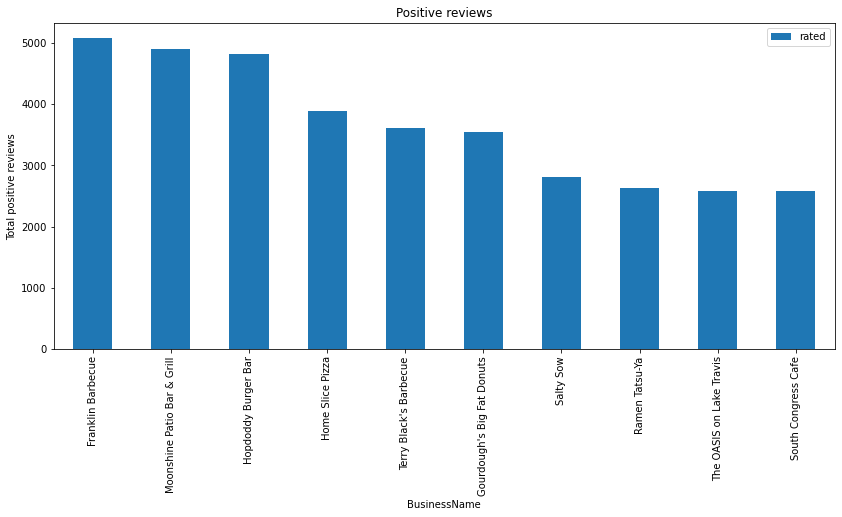

In [20]:
top_count= 10
right=pd.DataFrame(businessesInAustin[['business_id',"name","categories"]].values,
                    columns=['business_id',"BusinessName","categories"])

top_business_data = pd.merge(topbusiness,right=right, how="inner",on='business_id')
top_business_data.sort_values("rated")[::-1][:top_count].plot(x="BusinessName",y="rated", 
                                                   kind="bar",figsize=(14,6),
                                                   title='Positive reviews').set_ylabel("Total positive reviews")

These businesses have the most number of positive reviews.

But how do we create a model to see how businesses are doing overtime?

In [21]:
review_df["date"]=  pd.to_datetime(review_df["date"], format='%Y-%m-%d')
review_df['year'] = review_df.date.dt.year

In [22]:
#function to plot reviews by year
def positive_review_trend(title, business_name,business_id):
    #total reviews per year
    useful_b = review_df.loc[review_df['business_id'] == business_id]
    useful_b = useful_b.groupby(['year']).size().reset_index(name='counts')
    series = pd.Series(useful_b["counts"].values, index=useful_b["year"].values, name='Review trend')
    axes = series.plot(kind="bar",figsize=(10, 7))
    plt.xlabel('Year', axes=axes)
    plt.ylabel(title, axes=axes)
    plt.title('Review trend of {}'.format(business_name), axes=axes)
    plt.show()

In [23]:
# remove punctuation and stopwords
def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())
    x = [w for w in x.split() if w not in set(stopwords)]
    return ' '.join(x)

i = nltk.corpus.stopwords.words('english')
j = list(string.punctuation)
stopwords = set(i).union(j)

In [24]:
def create_positive_wordCloud(business_name, business_id):
    singleBusinessreviews = review_df.loc[review_df['business_id']==business_id]
    singleBusinessreviews = singleBusinessreviews.loc[review_df["stars"]>3]
    singleBusinessreviews['text_clear'] = singleBusinessreviews['text'].apply(preprocess)
    wc = WordCloud(width=1600, height=800, random_state=1, max_words=200000000)
    wc.generate(str(singleBusinessreviews['text_clear']))
    plt.figure(figsize=(20,10), facecolor='k')
    plt.title("Word Cloud for "+business_name, fontsize=14,color='white')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=10)
    plt.show()

In [25]:
def create_negative_wordCloud(business_name, business_id):
    singleBusinessreviews = review_df.loc[review_df['business_id']==business_id]
    singleBusinessreviews = singleBusinessreviews.loc[review_df["stars"]<3]
    singleBusinessreviews['text_clear'] = singleBusinessreviews['text'].apply(preprocess)
    wc = WordCloud(width=1600, height=800, random_state=1, max_words=200000000)
    wc.generate(str(singleBusinessreviews['text_clear']))
    plt.figure(figsize=(20,10), facecolor='k')
    plt.title("Word Cloud for "+business_name, fontsize=14,color='white')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=10)
    plt.show()

In [26]:
def averageRatingsPerYear(business_name, business_id):
    singleBusinessreviews = review_df.loc[review_df['business_id']==business_id]
    singleBusinessreviews.groupby(singleBusinessreviews.date.dt.year)['stars'].mean().plot(kind='bar', figsize=(12, 7))
    plt.title(business_name+" ratings in different years", fontsize=20)
    plt.xlabel('Month', fontsize=18)
    plt.ylabel('number of reviews', fontsize=14)
    plt.show()

In [27]:
def numberOfReviewsPerMonth(business_name, business_id):
    singleBusinessreviews = review_df.loc[review_df['business_id']==business_id]
    singleBusinessreviews.groupby(singleBusinessreviews.date.dt.month)['stars'].count().plot(kind='bar', figsize=(12, 7))
    # find average number of reviews for each month , (group by month)
    #singleBusinessreviews.groupby(singleBusinessreviews.date.dt.month).groupby(singleBusinessreviews.date.dt.year)['stars'].count().mean().plot(kind='bar', figsize=(12, 7))
    plt.title(business_name+" review numbers in different months", fontsize=20)
    plt.xlabel('Year', fontsize=18)
    plt.ylabel('Stars', fontsize=18)
    plt.show()

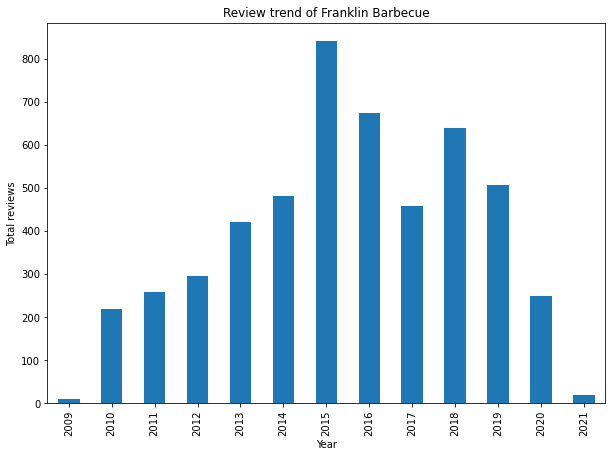

In [28]:
business_ids = top_business_data.sort_values("rated")[::-1][:2].business_id.values
business_names = top_business_data.sort_values("rated")[::-1][:2]["BusinessName"].values

positive_review_trend("Total reviews", business_names[0], business_ids[0])

We can see how the number of reviews is decreasing from 2015 for Franklin Barbecue. This model can be used for other businesses as well. Using this we can see the increase/decrease in customer flow to a business.

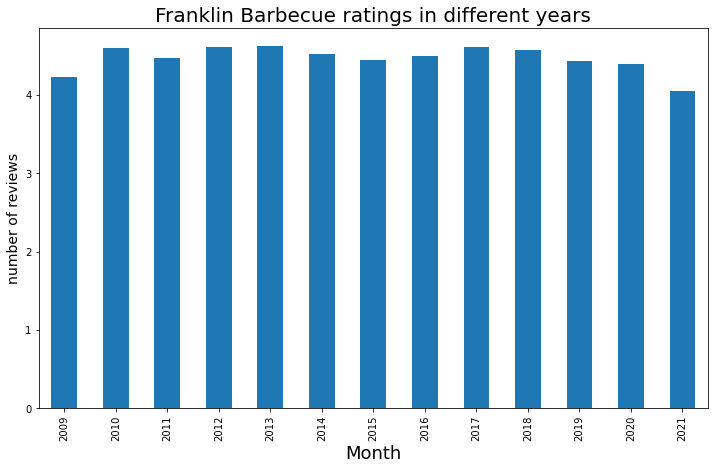

In [29]:
averageRatingsPerYear( business_names[0], business_ids[0])

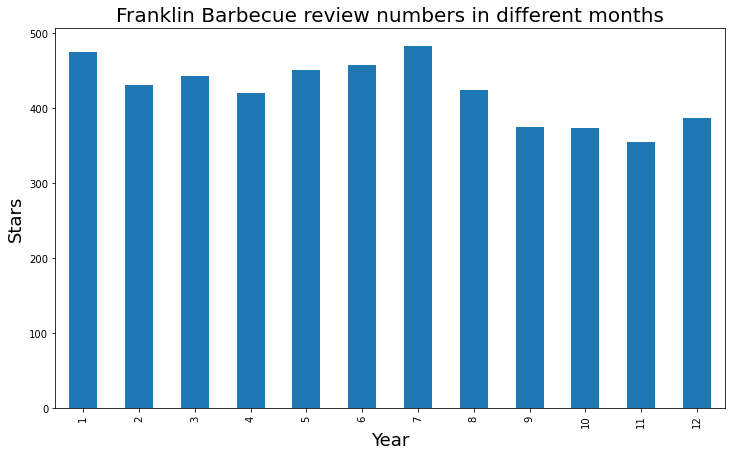

In [30]:
numberOfReviewsPerMonth( business_names[0], business_ids[0])

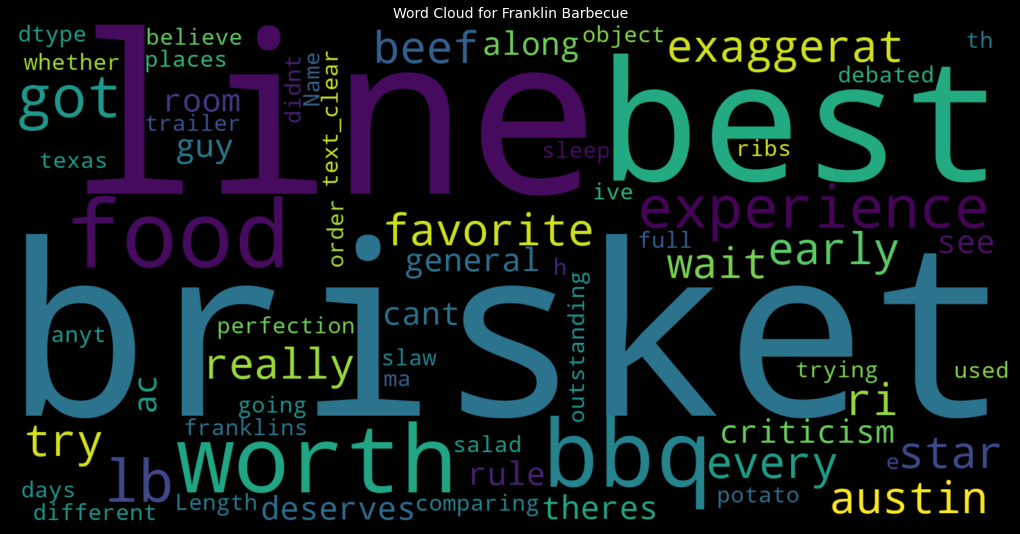

In [31]:
create_positive_wordCloud( business_names[0], business_ids[0])

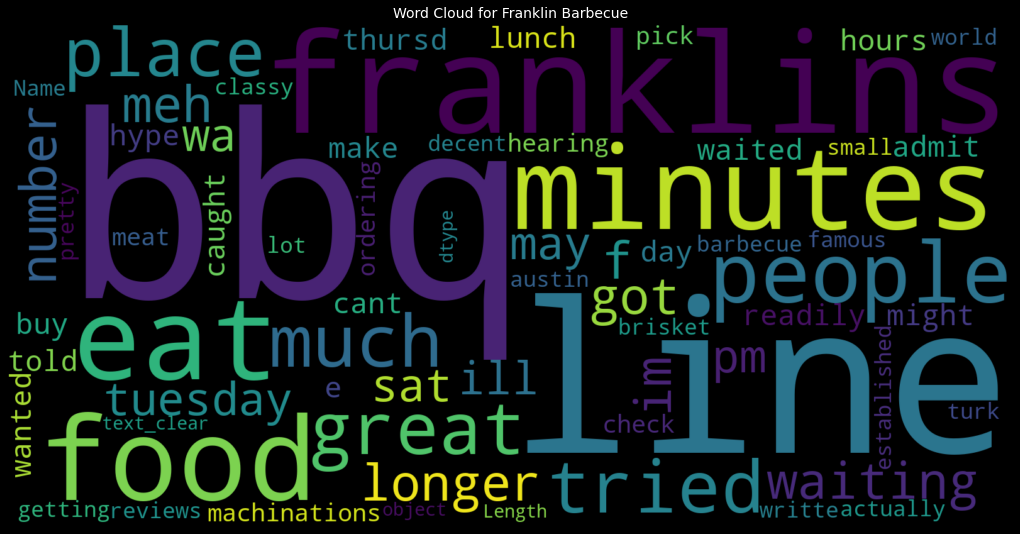

In [32]:
create_negative_wordCloud( business_names[0], business_ids[0])

### Ok, so the business improve futher by looking at the negative reviews and the words in them.

## Text Analysis to derive business insights

#### For this section let's look at what our reviews are focusing on. Let's take the reviews for Franklin Barbecue

If you go on to Franklin Barbecue website at URL(https://franklinbbq.com/), that we crawled using our crawler, we get the following information about the business.

In [33]:
business_names[1]

'Moonshine Patio Bar & Grill'

In [34]:
MoonshineMetaInfo = {'description': "Moonshine serves up innovative down-home cooking in a casual atmosphere, steeped in Austin, Texas' historic Waterloo Compound.Moonshine serves up innovative down-home cooking in a casual atmosphere, steeped in Austin, Texas' historic Waterloo Compound.Moonshine serves up innovative down-home cooking in a casual atmosphere, steeped in Austin, Texas' historic Waterloo Compound.Moonshine serves up innovative down-home cooking in a casual atmosphere, steeped in Austin, Texas' historic Waterloo Compound.Moonshine serves up innovative down-home cooking in a casual atmosphere, steeped in Austin, Texas' historic Waterloo Compound.Moonshine serves up innovative down-home cooking in a casual atmosphere, steeped in Austin, Texas' historic Waterloo Compound.Moonshine serves up innovative down-home cooking in a casual atmosphere, steeped in Austin, Texas' historic Waterloo Compound.", 'keywords': 'moonshine, restaurant, Moonshine, austin, downtown austin, convention, southern cooking, drinks, happy hour, moonshine bar & grill, best brunch, Classic American Comfort Food, steaks & seafood, downtown, Southern Comfort, valet, private parties, full bar, local, banquets, families welcome, austin originalmoonshine, restaurant, Moonshine, austin, downtown austin, convention, southern cooking, drinks, happy hour, moonshine bar & grill, best brunch, Classic American Comfort Food, steaks & seafood, downtown, Southern Comfort, valet, private parties, full bar, local, banquets, families welcome, austin originalmoonshine, restaurant, Moonshine, austin, downtown austin, convention, southern cooking, drinks, happy hour, moonshine bar & grill, best brunch, Classic American Comfort Food, steaks & seafood, downtown, Southern Comfort, valet, private parties, full bar, local, banquets, families welcome, austin originalmoonshine, restaurant, Moonshine, austin, downtown austin, convention, southern cooking, drinks, happy hour, moonshine bar & grill, best brunch, Classic American Comfort Food, steaks & seafood, downtown, Southern Comfort, valet, private parties, full bar, local, banquets, families welcome, austin originalmoonshine, restaurant, Moonshine, austin, downtown austin, convention, southern cooking, drinks, happy hour, moonshine bar & grill, best brunch, Classic American Comfort Food, steaks & seafood, downtown, Southern Comfort, valet, private parties, full bar, local, banquets, families welcome, austin originalmoonshine, restaurant, Moonshine, austin, downtown austin, convention, southern cooking, drinks, happy hour, moonshine bar & grill, best brunch, Classic American Comfort Food, steaks & seafood, downtown, Southern Comfort, valet, private parties, full bar, local, banquets, families welcome, austin originalmoonshine, restaurant, Moonshine, austin, downtown austin, convention, southern cooking, drinks, happy hour, moonshine bar & grill, best brunch, Classic American Comfort Food, steaks & seafood, downtown, Southern Comfort, valet, private parties, full bar, local, banquets, families welcome, austin original'}
MoonshineMetaInfo

{'description': "Moonshine serves up innovative down-home cooking in a casual atmosphere, steeped in Austin, Texas' historic Waterloo Compound.Moonshine serves up innovative down-home cooking in a casual atmosphere, steeped in Austin, Texas' historic Waterloo Compound.Moonshine serves up innovative down-home cooking in a casual atmosphere, steeped in Austin, Texas' historic Waterloo Compound.Moonshine serves up innovative down-home cooking in a casual atmosphere, steeped in Austin, Texas' historic Waterloo Compound.Moonshine serves up innovative down-home cooking in a casual atmosphere, steeped in Austin, Texas' historic Waterloo Compound.Moonshine serves up innovative down-home cooking in a casual atmosphere, steeped in Austin, Texas' historic Waterloo Compound.Moonshine serves up innovative down-home cooking in a casual atmosphere, steeped in Austin, Texas' historic Waterloo Compound.",
 'keywords': 'moonshine, restaurant, Moonshine, austin, downtown austin, convention, southern cook

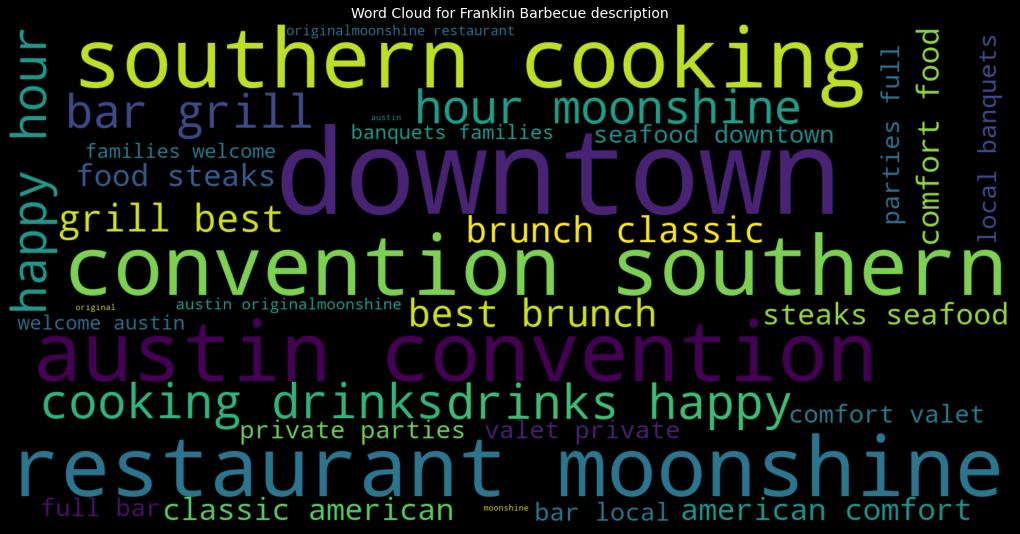

In [35]:
processedKeywords = preprocess(MoonshineMetaInfo['keywords'])
wc = WordCloud(width=1600, height=800, random_state=1, max_words=200000000)
wc.generate(str(processedKeywords))
plt.figure(figsize=(20,10), facecolor='k')
plt.title("Word Cloud for Franklin Barbecue description", fontsize=14,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

### Generating a corpus by looking at the keywords and wordcloud

In [36]:
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year
0,Qv_lQb1Yu9DGsUO3r-enNw,Ngl83gs3n22SzLAsNw2znw,iZxfWlfNPXV_0S1xO8QNSQ,2,3,0,0,Disappointing. Bolt is a follow up of Fanny's ...,2013-01-02 18:12:15,2013
1,m1GlqFGIN5eayrbb2IbRZg,B7YSV6r1ePAXc69FkDDuZw,wZgUAuDuEGPEzKK-PsngKQ,1,0,0,0,I wish I could give them zero stars. The call ...,2014-06-27 22:06:55,2014
2,GDgXjXSZCA1iNQWD7OHXfg,1RCRKuHgP3FskGUVnmFdxg,mOnesB4IF9j6-ZmHoOHOig,4,0,0,0,I think their rice dishes are way better than ...,2017-05-26 03:05:46,2017
3,OMGz2BaL3bzRvY2hEp1-wQ,d01SZKYmReEar7varZB0HQ,I2OblwJG8_XzFxxoHU0vVQ,4,5,1,1,I just had my lasik done last week and I am re...,2010-05-14 14:33:54,2010
4,dprQ8G5J01mlV6Z5W19LtQ,ednTYrjsoD3HtpZ-Z29SAQ,AW_dMex_BXFzgBJFxAjDuQ,5,0,0,0,Erika was amazing! After months of trying to f...,2016-08-03 22:55:45,2016


In [97]:
singleBusinessreviews = review_df.loc[review_df['business_id']==business_ids[0]]
singleBusinessreviews['text_clear'] = singleBusinessreviews['text'].apply(preprocess)

# Analysis keywords for each category
bar = "|".join(('drink', 'drinks', 'bar', 'happy hour', 'bartender', 'brew', 'brewery', 'beer', 'barrel', 'shots', 'whisky', 'bourbon', 'tequila'))
service = "|".join(( 'customer', 'customers', 'clients', 'convention', 'casual', 'fast', 'wait', 'long', 'service', 'welcome', 'slow', 'comfortable', 'kind', 'waiter', 'host', 'families'))
food = "|".join(('american', 'cooking', 'chef', 'food', 'steaks', 'seafood', 'clam', 'fish', 'breakfast','delicious','bbq', 'brisket', 'barbeque', 'brunch', 'lunch', 'dinner', 'grill', 'bruger', 'burgers', 'banquets','steak','fish', 'parties', 'southern', 'mexican', 'comfort', 'south', 'fries', 'fried', 'wings', 'sandwiches', 'sandwich', 'chicken'))
place = "|".join(('comfortable', 'cheap', 'crowded', 'parking', 'expensive', 'room', 'money', 'clean', 'dirty', 'crowd', 'dark', 'light', 'small', 'big', 'parties', 'parties', 'smelly', 'wipe', 'bathroom', 'toilet', 'disgusting' ,'terrible', 'great', 'awesome', 'memories', 'good', 'bad', 'ugly', 'beautiful'))

elements = [bar, service, food, place]

for element in elements:
    singleBusinessreviews[element[0:3]] =singleBusinessreviews['text_clear'].str.contains(element)

#renaming the columns instead of having random words
singleBusinessreviews.rename(columns = {'dri': 'bar', 'cus': 'service', 'ame': 'food', 'com': 'place'}, inplace = True)
singleBusinessreviews.head()

C:\Users\praba\anaconda3\envs\honorsCrawler\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\praba\anaconda3\envs\honorsCrawler\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\praba\anaconda3\envs\honorsCrawler\lib\site-packages\pandas\core\frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the d

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year,text_clear,bar,service,food,place
297490,0JrIJtZzfHn113ee69Lpng,YjKi-kVBSbSR2koQwWdCUA,MGzro82Fi4LYvc86acoONQ,3,3,2,2,Overall experience 3. \nFood 5. \n\nIt was our...,2017-09-09 01:13:12,2017,overall experience food last day austin seen c...,False,True,True,True
297503,0C5_P9WoJQo2YfB2ozCD8w,K_1lqJTEJmzpYV__6cwfGw,MGzro82Fi4LYvc86acoONQ,5,0,0,0,Every star is for the brisket! It is the best ...,2014-02-24 00:32:18,2014,every star brisket best brisket ever exaggerat...,False,True,True,True
297504,Z3q_5phq3glW5yTDqPGv7Q,abgt_ZUoSs9OxOHRmYC3-w,MGzro82Fi4LYvc86acoONQ,5,0,0,0,Our favorite BBQ in Austin. Get in line early...,2016-09-30 21:30:17,2016,favorite bbq austin get line early try beef ri...,False,True,True,True
297515,UmSZWFE2kvCnxOfvgpmnEQ,8AB3_ix5W2GIVAtUl7IvSg,MGzro82Fi4LYvc86acoONQ,5,0,0,0,It really is worth the wait. My general rule ...,2016-10-26 15:15:30,2016,really worth wait general rule food along line...,False,True,True,True
297517,bQ3H31v2bsMLo7LtS8aRCw,_HiI0WhqKegnZRg5OW-s_Q,MGzro82Fi4LYvc86acoONQ,5,1,0,1,I can't see where there's any room for critici...,2015-05-26 17:36:40,2015,cant see theres room criticism guy deserves ac...,False,False,False,True


In [98]:
print(singleBusinessreviews.bar.value_counts(), '\n')
print(singleBusinessreviews.service.value_counts(), '\n')
print(singleBusinessreviews.food.value_counts(), '\n')
print(singleBusinessreviews.place.value_counts(), '\n')

False    3222
True     1849
Name: bar, dtype: int64 

True     3905
False    1166
Name: service, dtype: int64 

True     4659
False     412
Name: food, dtype: int64 

True     3404
False    1667
Name: place, dtype: int64 



In [99]:
#function to return a set of keywords in a row for a ceratian category
def listReviewsAccordingToKeywords(x, category):
    list_of_words = x.split(" ")
    category=category.split("|")
    out_data = []
    for word in list_of_words:
        if word in category:
            out_data.append(word)
    return out_data

#apply that function to our dataframe
singleBusinessreviews['bar_words'] = singleBusinessreviews['text_clear'].apply(listReviewsAccordingToKeywords, category = bar)
singleBusinessreviews['service_words'] = singleBusinessreviews['text_clear'].apply(listReviewsAccordingToKeywords, category = service)
singleBusinessreviews['food_words'] = singleBusinessreviews['text_clear'].apply(listReviewsAccordingToKeywords, category = food)
singleBusinessreviews['place_words'] = singleBusinessreviews['text_clear'].apply(listReviewsAccordingToKeywords, category = place)

C:\Users\praba\anaconda3\envs\honorsCrawler\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\praba\anaconda3\envs\honorsCrawler\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\praba\anaconda3\envs\honorsCrawler\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [100]:
singleBusinessreviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year,text_clear,bar,service,food,place,bar_words,service_words,food_words,place_words
297490,0JrIJtZzfHn113ee69Lpng,YjKi-kVBSbSR2koQwWdCUA,MGzro82Fi4LYvc86acoONQ,3,3,2,2,Overall experience 3. \nFood 5. \n\nIt was our...,2017-09-09 01:13:12,2017,overall experience food last day austin seen c...,False,True,True,True,[],[],"[food, chef, bbq, brisket, delicious, brisket,...","[great, dirty, great]"
297503,0C5_P9WoJQo2YfB2ozCD8w,K_1lqJTEJmzpYV__6cwfGw,MGzro82Fi4LYvc86acoONQ,5,0,0,0,Every star is for the brisket! It is the best ...,2014-02-24 00:32:18,2014,every star brisket best brisket ever exaggerat...,False,True,True,True,[],[wait],"[brisket, brisket, brisket]",[good]
297504,Z3q_5phq3glW5yTDqPGv7Q,abgt_ZUoSs9OxOHRmYC3-w,MGzro82Fi4LYvc86acoONQ,5,0,0,0,Our favorite BBQ in Austin. Get in line early...,2016-09-30 21:30:17,2016,favorite bbq austin get line early try beef ri...,False,True,True,True,[],"[wait, wait]","[bbq, brisket, bbq, bbq, bbq]","[room, good]"
297515,UmSZWFE2kvCnxOfvgpmnEQ,8AB3_ix5W2GIVAtUl7IvSg,MGzro82Fi4LYvc86acoONQ,5,0,0,0,It really is worth the wait. My general rule ...,2016-10-26 15:15:30,2016,really worth wait general rule food along line...,False,True,True,True,[],"[wait, wait, long, wait, wait]","[food, bbq, bbq]",[good]
297517,bQ3H31v2bsMLo7LtS8aRCw,_HiI0WhqKegnZRg5OW-s_Q,MGzro82Fi4LYvc86acoONQ,5,1,0,1,I can't see where there's any room for critici...,2015-05-26 17:36:40,2015,cant see theres room criticism guy deserves ac...,False,False,False,True,[],[],[],[room]


In [101]:
descriptionDict = {}

def findWordsInFrame(x):
    for singleWord in set(x['food_words']):
        if singleWord in descriptionDict.keys():
            descriptionDict[singleWord]['count']+=1
        else:
            descriptionDict[singleWord]={'count':0, 'positive':0, 'negative':0}

        if(x['stars']>3):
            descriptionDict[singleWord]['positive']+=1
        else:
            descriptionDict[singleWord]['negative']+=1

#for each of the reviews let's see how many of the reviews have the words in them
singleBusinessreviews.apply(findWordsInFrame, axis=1)
    
descriptionDict

{'brisket': {'count': 3490, 'positive': 3201, 'negative': 290},
 'delicious': {'count': 718, 'positive': 692, 'negative': 27},
 'bbq': {'count': 2728, 'positive': 2371, 'negative': 358},
 'food': {'count': 1747, 'positive': 1512, 'negative': 236},
 'chef': {'count': 43, 'positive': 38, 'negative': 6},
 'lunch': {'count': 245, 'positive': 216, 'negative': 30},
 'chicken': {'count': 30, 'positive': 27, 'negative': 4},
 'southern': {'count': 24, 'positive': 22, 'negative': 3},
 'sandwiches': {'count': 90, 'positive': 84, 'negative': 7},
 'comfort': {'count': 5, 'positive': 6, 'negative': 0},
 'cooking': {'count': 50, 'positive': 42, 'negative': 9},
 'sandwich': {'count': 262, 'positive': 243, 'negative': 20},
 'dinner': {'count': 51, 'positive': 48, 'negative': 4},
 'barbeque': {'count': 119, 'positive': 100, 'negative': 20},
 'wings': {'count': 4, 'positive': 4, 'negative': 1},
 'south': {'count': 49, 'positive': 39, 'negative': 11},
 'breakfast': {'count': 109, 'positive': 103, 'negativ

### From this we can get a sense of what the business can improve on. For example, Specific negative reviews can be accessed for each business to see what the customer did not like and hence can be improved for future customers.

### The same method can be applied to other type of business data to search for keywords and the general sentiments associated with each section or keyword.

### Determine satisfaction level over time

In [117]:
# draw a graph for count against time 
def getCountOfPositiveKeyword(x, keyword):
    if (keyword in x['food_words']) and x['stars']>3:
        return 1
    else:
        return 0

def getCountOfNegativeKeyword(x, keyword):
    if (keyword in x['food_words']) and x['stars']<=3:
        return 1
    else:
        return 0
    
#let's see how the reviews are based on each month for briskets
singleBusinessreviews['brisket_count_positive'] = singleBusinessreviews.apply(getCountOfPositiveKeyword, keyword="bbq", axis =1)
singleBusinessreviews['brisket_count_negative']  = singleBusinessreviews.apply(getCountOfNegativeKeyword, keyword="bbq", axis=1)

C:\Users\praba\anaconda3\envs\honorsCrawler\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\praba\anaconda3\envs\honorsCrawler\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Text(0, 0.5, 'monthly interval')

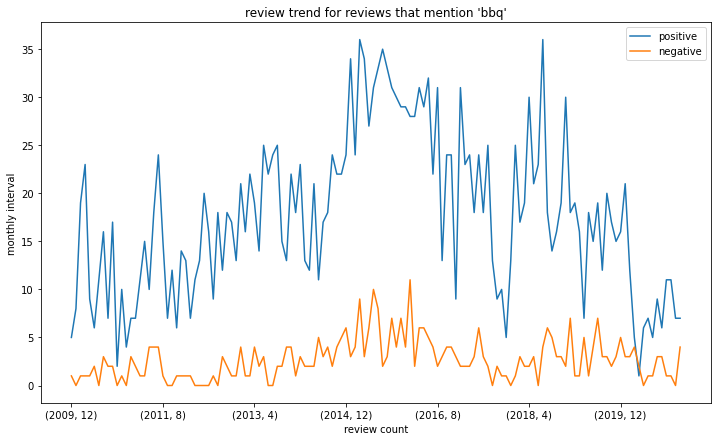

In [129]:
difference = pd.DataFrame([])
difference['positive'] = singleBusinessreviews.groupby([(singleBusinessreviews.date.dt.year),(singleBusinessreviews.date.dt.month)])['brisket_count_positive'].sum()
difference['negative'] = singleBusinessreviews.groupby([(singleBusinessreviews.date.dt.year),(singleBusinessreviews.date.dt.month)])['brisket_count_negative'].sum()
ax = difference.plot(title="review trend for reviews that mention 'bbq'", figsize=(12, 7))
ax.set_xlabel("review count")
ax.set_ylabel("monthly interval")

### Looks like towards the end the quality of bbq started deteriorating

## Predicting Sentiments from Reviews

Now let's see if we can actually predict how the user is feeling by looking at Reviews

In [41]:
#score > 3 as positive sentiment and score <3 as negative sentiment
sentiment_df = review_df[review_df['stars'] != 3]
sentiment_df['sentiment'] = sentiment_df['stars'].apply(lambda rating : +1 if rating > 3 else -1)

C:\Users\praba\anaconda3\envs\honorsCrawler\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
#applying preprocess on the text
sentiment_df['text_clear'] = sentiment_df['text'].apply(preprocess)

C:\Users\praba\anaconda3\envs\honorsCrawler\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
#here we are taking just 20% of the dataset because of limitation in computing power
new_df = sentiment_df.sample(frac =.2)
features = new_df.iloc[:, 11].values
labels = new_df.iloc[:, 10].values

In [44]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(features).toarray()

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [49]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=50, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=0)

In [50]:
predictions = text_classifier.predict(X_test)

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[ 8630  3504]
 [ 1044 38656]]
              precision    recall  f1-score   support

          -1       0.89      0.71      0.79     12134
           1       0.92      0.97      0.94     39700

    accuracy                           0.91     51834
   macro avg       0.90      0.84      0.87     51834
weighted avg       0.91      0.91      0.91     51834

0.9122583632364857


### improvements to this model: enhance the model by adding (useful, funny, cool ) features for each reviews